# Performing a Cluster Analysis

One-Trick-Pony :D

Basically clustering the issues, by people working on them and commenting on them, as well as priority and date of creation. Maybe this will reconstruct what different aspects Zookeeper has (e.g. Server development, client-side, User-Interface etc.)

In [8]:
import pymongo
from pymongo import MongoClient

import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib 
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

client = MongoClient('localhost', 27017)
db = client.smartshark_test

In [9]:
events = pd.DataFrame(list(db.event.find()))
issues = pd.DataFrame(list(db.issue.find()))
authors = pd.DataFrame(list(db.people.find()))
comments = pd.DataFrame(list(db['issue_comment'].find()))


comments.author_id = comments.author_id.astype('string')
comments.issue_id = comments.issue_id.astype('string')
authors._id = authors._id.astype('string')
issues._id = issues._id.astype('string')
issues.priority = issues.priority.fillna('nan',inplace=False)
events.issue_id = events.issue_id.astype('string')
events.author_id = events.author_id.astype('string')

cmap = {'Trivial':'green', 'Minor':'yellow', 'Major':'orange', 'Critical':'red', 'Blocker':'grey', 'nan':'white'}


# Making contributing author vectors

In [10]:
empty_author_vector = pd.DataFrame(index=authors._id, columns=['is_there'])
empty_author_vector['is_there']=0

In [11]:
def get_comment_author_vector(issue_id):
    comment_authors_to_issue = comments[comments.issue_id == issue_id].author_id
    comment_author_vector = empty_author_vector.copy()
    if list(comment_authors_to_issue):
        comment_author_vector.loc[list(comment_authors_to_issue)] = 1
    return comment_author_vector

In [12]:
def get_event_author_vector(issue_id):
    event_authors_to_issue = events[events.issue_id == issue_id].author_id
    event_author_vector = empty_author_vector.copy()
    if list(event_authors_to_issue):
        event_author_vector.loc[list(event_authors_to_issue)] = 1
    return event_author_vector   

## Making the priority vectors

In [13]:
def get_priority_vector(issue_id):
    priority_vector_dict = {
        'Trivial':[1,0,0,0,0,0], 
        'Minor':[0,1,0,0,0,0], 
        'Major':[0,0,1,0,0,0], 
        'Critical':[0,0,0,1,0,0], 
        'Blocker':[0,0,0,0,1,0], 
        'nan':[0,0,0,0,0,1]
    }
    return np.array(priority_vector_dict[issues.priority[issues._id==issue_id].iloc[0] ])

## Ignoring the Time for now

In [26]:
issue_sample = issues._id.dropna().sample(1000)
issue_test = issue_sample.iloc[600:]
issue_train = issue_sample.iloc[:600]

list_of_vectors = [
    np.append(
        np.append(
            get_comment_author_vector(issue_id), get_event_author_vector(issue_id)
        ), 
        get_priority_vector(issue_id))
for issue_id in issue_train]

list_of_test_vectors = [
    np.append(
        np.append(
            get_comment_author_vector(issue_id), get_event_author_vector(issue_id)
        ), 
        get_priority_vector(issue_id))
for issue_id in issue_test]

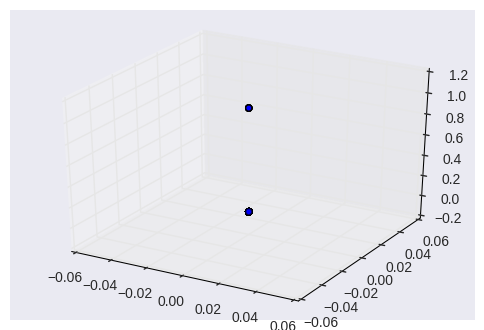

In [27]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(list_of_vectors)[:,0], np.array(list_of_vectors)[:,1], np.array(list_of_vectors)[:,2]) 

# The first FUN-Part: PCA

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [29]:
pca = PCA(n_components=0.95)
pca.fit(list_of_vectors)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [30]:
X = pca.transform(list_of_vectors)

In [31]:
X = np.array(X)

In [32]:
X

array([[ -1.28920655e-01,   1.06408988e+00,  -2.27936220e-01, ...,
         -8.83624771e-18,   7.91467586e-18,  -3.25260652e-19],
       [  1.12176809e+00,  -5.25248725e-01,   1.08330189e+00, ...,
          1.65828722e-16,  -9.21571847e-18,  -4.28747749e-16],
       [ -1.01600567e+00,  -2.47155112e-01,  -5.16345235e-01, ...,
         -1.05763922e-16,   2.23887749e-16,   2.40150781e-16],
       ..., 
       [  3.76649719e-01,   1.79055349e+00,  -1.75272172e-01, ...,
         -1.93654771e-15,   2.17447588e-15,   4.64309580e-15],
       [ -1.99667901e-01,  -4.37122815e-01,  -4.46044121e-01, ...,
          1.17093835e-17,  -7.82251867e-17,  -3.06503954e-16],
       [ -1.13333138e+00,  -5.09653303e-01,   6.91373787e-01, ...,
          9.86623977e-18,   1.37043155e-16,  -1.16280683e-16]])

In [33]:
icount=0

(0, 1, 2)


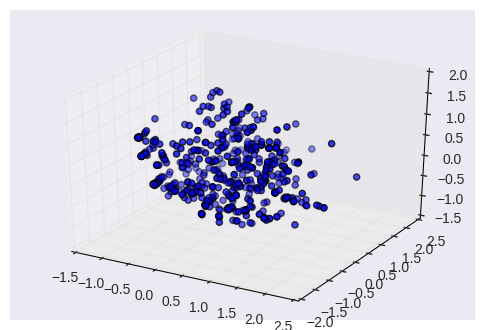

In [34]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13])
print(icount, icount+1, icount+2)
icount+=1

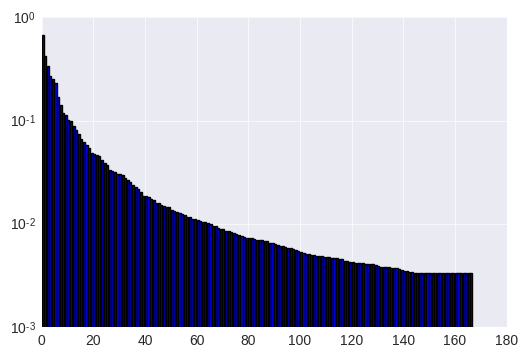

In [35]:
plt.close('all')
plt.bar(np.arange(len(pca.components_)), pca.explained_variance_)
plt.yscale('log')

<Container object of 167 artists>

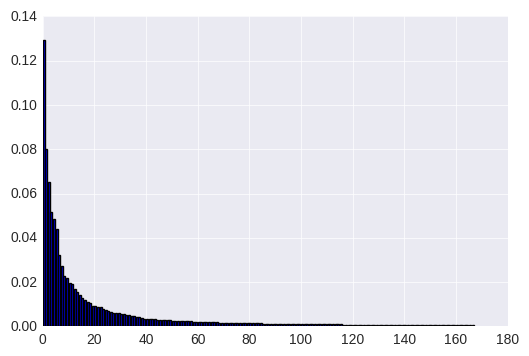

In [36]:
plt.close('all')
plt.bar(np.arange(len(pca.components_)),pca.explained_variance_ratio_)
#plt.yscale('log')

In [37]:
total_vector_index = empty_author_vector.append(empty_author_vector).append(pd.DataFrame(index=['Trivial', 'Minor','Major','Critical','Blocker','nan'], columns=['is_there']))

In [38]:
total_vector_names = total_vector_index.copy()
total_vector_names.index = [authors[authors._id==ind].username.iloc[0] if ind not in ['Trivial', 'Minor','Major','Critical','Blocker','nan'] else ind for ind in total_vector_names.index ]

In [39]:
principal_components = pd.DataFrame(index = total_vector_names.index, columns=range(1,14))

In [40]:
for i in range(len(pca.components_[:13])):
    principal_components[i+1]=pca.components_[i]

In [41]:
principal_components.sort_values(by=1, ascending=False).head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13
phunt,0.451622,-0.102349,-0.005543,0.250311,-0.393945,-0.004561,-0.002285,-0.153806,-0.179225,-0.060069,-0.124650,-0.186831,0.469734
mahadev,0.388974,-0.250447,-0.069848,-0.118072,0.203819,0.278439,-0.145644,0.228805,0.014174,0.077478,0.018391,0.242638,-0.073882
mahadev,0.388896,-0.275080,-0.062572,-0.006639,0.185832,0.447063,-0.149960,0.178806,-0.002388,-0.017064,0.128492,-0.085176,-0.020751
hudson,0.382155,0.216048,0.160725,0.009189,0.397498,-0.255126,-0.232961,-0.321862,-0.011164,0.284896,-0.376425,0.171195,-0.027018
phunt,0.364715,-0.087619,0.075844,0.230580,-0.542988,-0.329901,0.040295,0.104137,0.196189,0.117773,0.113882,0.137597,-0.413609


In [42]:
principal_components.sort_values(by=2, ascending=True).head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13
mahadev,0.388896,-0.275080,-0.062572,-0.006639,0.185832,0.447063,-0.149960,0.178806,-0.002388,-0.017064,0.128492,-0.085176,-0.020751
mahadev,0.388974,-0.250447,-0.069848,-0.118072,0.203819,0.278439,-0.145644,0.228805,0.014174,0.077478,0.018391,0.242638,-0.073882
phunt,0.451622,-0.102349,-0.005543,0.250311,-0.393945,-0.004561,-0.002285,-0.153806,-0.179225,-0.060069,-0.124650,-0.186831,0.469734
Minor,-0.054845,-0.100409,0.493498,-0.108255,-0.086297,0.123667,-0.006123,-0.238602,-0.422910,0.129371,0.344897,0.271414,-0.125222
phunt,0.364715,-0.087619,0.075844,0.230580,-0.542988,-0.329901,0.040295,0.104137,0.196189,0.117773,0.113882,0.137597,-0.413609


In [43]:
important_people = principal_components.abs().sum(axis=1)

In [44]:
important_people.sort_values(ascending=False)

hudson                         2.846261
phunt                          2.755129
hadoopqa                       2.716122
Minor                          2.505512
phunt                          2.384929
cnauroth                       2.325718
Major                          2.258735
mahadev                        2.110613
michi                          2.078279
michi                          2.048708
fpj                            1.979016
mahadev                        1.948718
fpj                            1.937730
breed                          1.857008
breed                          1.769889
rakeshr.radhakrishnan.potty    1.674836
rakeshr.radhakrishnan.potty    1.659578
shralex                        1.541355
shralex                        1.376153
rgs                            1.349470
camille                        1.326729
Critical                       1.216514
Trivial                        0.910374
camille                        0.886897
hdeng                          0.787839


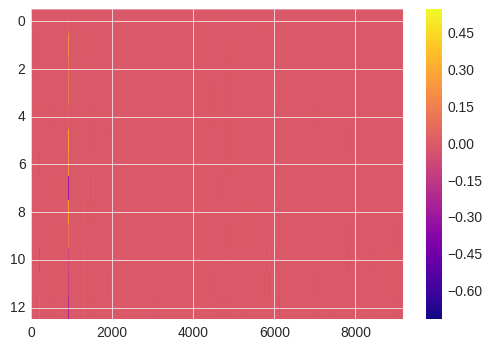

In [45]:
plt.close('all')
plt.imshow(pca.components_[:13], cmap='plasma', aspect='auto', interpolation='None')
plt.colorbar()
plt.savefig('principal_components.png')


# HAHA Only 13 dimensions left nice!!

In [46]:
plt.close('all')
ncls=[]
scores=[]
for ncl in range(2,20):
    model = KMeans(n_clusters=ncl)
    model.fit(X)
    ncls.append(ncl)
    scores.append(model.score(X))
    print('ncl: {}, score: {}'.format(ncl,model.score(X)))

ncl: 2, score: -2681.30765587
ncl: 3, score: -2499.15280193
ncl: 4, score: -2403.18222724
ncl: 5, score: -2330.01827558
ncl: 6, score: -2256.08908374
ncl: 7, score: -2213.0703973
ncl: 8, score: -2158.5454185
ncl: 9, score: -2115.15743935
ncl: 10, score: -2090.49010036
ncl: 11, score: -2035.51802391
ncl: 12, score: -2018.59900954
ncl: 13, score: -1989.11616311
ncl: 14, score: -1969.81468325
ncl: 15, score: -1946.85997158
ncl: 16, score: -1912.20112523
ncl: 17, score: -1908.63877787
ncl: 18, score: -1877.9609824
ncl: 19, score: -1867.84197935


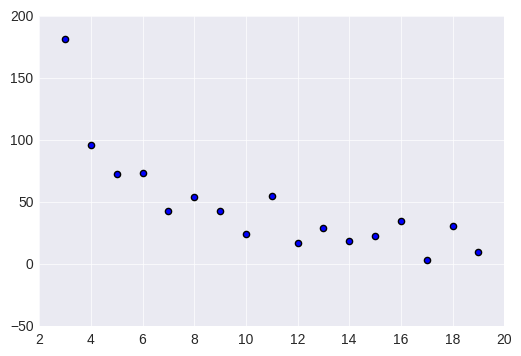

In [47]:
plt.scatter(ncls[1:], np.array(scores[1:])-np.array(scores[:-1]) )

In [48]:
model = KMeans(9)
model.fit(X)
model.score(X)

-2103.5026359141198

### Validation

In [49]:
Y = pca.transform(list_of_test_vectors)

In [50]:
model.score(Y)

-1125.1415190434145

In [68]:
%matplotlib inline

In [69]:
icount=0

(47, 48, 49)


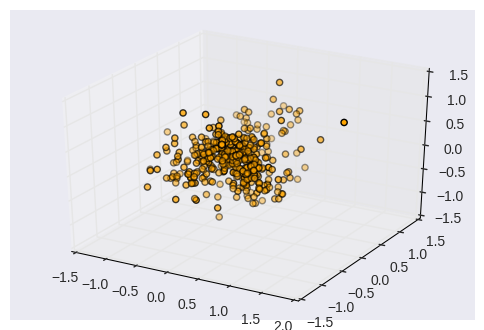

In [117]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_array = [cmap[prio] for prio in issues.priority.loc[issue_test.index]]

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13], c=color_array, cmap='Set1')
print(icount, icount+1, icount+2)
icount+=1
#plt.savefig('../presentation/clustering.png')

In [ ]:
icount=0
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13], c=model.labels_, cmap='Set1')
print(icount, icount+1, icount+2)
icount+=1
plt.savefig('../presentation/clustering.png')

In [54]:
from sklearn.cluster import AgglomerativeClustering

In [55]:
model_agglo = AgglomerativeClustering(n_clusters=13)
labels_agglo = model_agglo.fit_predict(X)

In [56]:
%matplotlib notebook

<IPython.core.display.Javascript object>


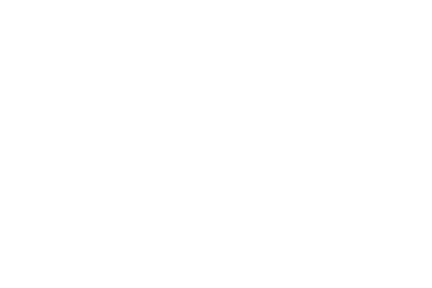

(0, 1, 2)


<IPython.core.display.Javascript object>


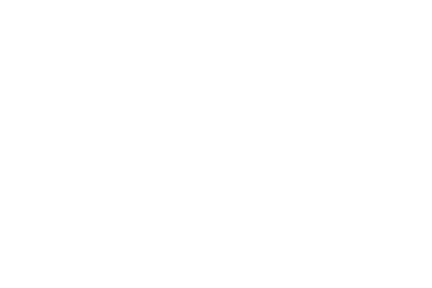

In [57]:
icount=0
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,(icount + 0)%13], X[:,(icount + 1)%13], X[:,(icount + 2)%13], c=labels_agglo, cmap='Set1')
print(icount, icount+1, icount+2)